In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
plt.rcParams['font.family'] = 'Malgun Gothic' # Set Korean font for matplotlib

import pandas_datareader as pdr
import FinanceDataReader as fdr
from fredapi import Fred

from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

# 0. Load Data

In [52]:
file_path = '/Users/jongheelee/Desktop/JH/주가예측/data/tech_df.csv'  # 파일 경로 및 파일명
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)
df = df.rename(columns={'Adj Close' : 'y'})
df = df.dropna()

# 1. Sample Code MO_RF

In [57]:
final_df = pd.DataFrame()
##################################################
n_lags = 10  
cutoff = '2023-04-01' # train split
period = pd.to_datetime('2023-04-01') # 현재시점 (이 시점 +1, +2, +3월 예측진행)
threshold = 0.000001
cutoff2 = pd.to_datetime(period) - pd.DateOffset(months=2)
##################################################
df_full = df.copy()
df_train = df_full[df_full['Date']<= cutoff]

# 상관계수 계산 및 강한 상관관계 변수 선택
corr_matrix = df_train.corr()
strong_corr_vars = corr_matrix['y'].abs()[corr_matrix['y'].abs() >= threshold].index.tolist()
strong_corr_vars = [var for var in strong_corr_vars if var != 'Date']  # 'ds' 칼럼 제외

df_train.set_index('Date', inplace=True)
def create_lagged_features(df_train, target_column, selected_vars, n_lags): # 시차를 두고 데이터를 생성합니다.
    X, y = [], []
    for i in range(n_lags, len(df_train) - n_lags + 1):  # 끝에서 n_lags만큼 덜 반복
        X_lagged = df_train[selected_vars].iloc[i-n_lags:i].values.flatten()  # 선택된 X 변수만 포함
        X.append(X_lagged)
        y.append(df_train[target_column].iloc[i:i+n_lags].values)
    return np.array(X), np.array(y)

X, y = create_lagged_features(df_train, 'y', strong_corr_vars, n_lags) # 3개월 시차를 두고 데이터 생성
print(f"Processing: X shape - {X.shape}, y shape - {y.shape}")

model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)) # MultiOutputRegressor를 사용하여 모델 학습
model.fit(X, y)

selected_rows = df_full[df_full['Date'] >= cutoff].iloc[:n_lags]
last_known_values = selected_rows[strong_corr_vars].values.flatten().reshape(1, -1)
predictions = model.predict(last_known_values) # 예측

# 실제 값과 예측 값을 비교하는 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': df_full['Date'],
    'Actual': df_full['y']
})
comparison_df = comparison_df[comparison_df['Date'] >= period].copy()

# 필요한 열만 추출하여 최종 데이터프레임 구성
if len(comparison_df) >= n_lags:
    result_df = pd.DataFrame({
        '현재월': [comparison_df['Date'].iloc[2]],
        'Actual+1': [comparison_df['Actual'].iloc[3]],
        'Actual+2': [comparison_df['Actual'].iloc[4]],
        'Actual+3': [comparison_df['Actual'].iloc[5]],
        'Pred+1': predictions.flatten()[0],
        'Pred+2': predictions.flatten()[1],
        'Pred+3': predictions.flatten()[2]
    })

# Function to calculate accuracy for a single row
def calculate_row_accuracy(row, actual_col, forecast_col):
    if pd.isna(row[actual_col]) or pd.isna(row[forecast_col]):
        return np.nan
    else:
        mape = mean_absolute_percentage_error([row[actual_col]], [row[forecast_col]])
        accuracy = (mape * 100)
        return accuracy

# Calculate accuracy for each row and add to the DataFrame
result_df['Accuracy M+1'] = result_df.apply(calculate_row_accuracy, axis=1, args=('Actual+1', 'Pred+1'))
result_df['Accuracy M+2'] = result_df.apply(calculate_row_accuracy, axis=1, args=('Actual+2', 'Pred+2'))
result_df['Accuracy M+3'] = result_df.apply(calculate_row_accuracy, axis=1, args=('Actual+3', 'Pred+3'))
result_df['Mean Accuracy'] = result_df[['Accuracy M+1', 'Accuracy M+2', 'Accuracy M+3']].mean(axis=1)

# Function to calculate RMSE for a single row
def calculate_row_rmse(row, actual_col, forecast_col):
    if pd.isna(row[actual_col]) or pd.isna(row[forecast_col]):
        return np.nan
    else:
        rmse = np.sqrt((row[actual_col] - row[forecast_col]) ** 2)
        return rmse

# Calculate RMSE for each row and add to the DataFrame
result_df['RMSE M+1'] = result_df.apply(calculate_row_rmse, axis=1, args=('Actual+1', 'Pred+1'))
result_df['RMSE M+2'] = result_df.apply(calculate_row_rmse, axis=1, args=('Actual+2', 'Pred+2'))
result_df['RMSE M+3'] = result_df.apply(calculate_row_rmse, axis=1, args=('Actual+3', 'Pred+3'))
result_df['Mean RMSE'] = result_df[['RMSE M+1', 'RMSE M+2', 'RMSE M+3']].mean(axis=1)



result_df

Processing: X shape - (2255, 230), y shape - (2255, 10)


,현재월,Actual+1,Actual+2,Actual+3,Pred+1,Pred+2,Pred+3,Accuracy M+1,Accuracy M+2,Accuracy M+3,Mean Accuracy,RMSE M+1,RMSE M+2,RMSE M+3,Mean RMSE
0,2023-04-05,163.374817,160.765335,159.544937,163.576547,163.119094,161.505047,0.123477,1.464096,1.228563,0.938712,0.20173,2.353759,1.960109,1.505199


# 2. 1번 코드를 Many Term (Without 재학습)

In [58]:
final_df = pd.DataFrame()

##################################################
n_lags = 3  
cutoff = '2022-07-01' # train split
period = pd.to_datetime('2022-07-01') # 현재시점 (이 시점 +1, +2, +3월 예측진행)
threshold = 0.000001
cutoff2 = pd.to_datetime(period) - pd.DateOffset(months=2)
##################################################

for i in range (9):

    df_full = df.copy()
    df_train = df_full[df_full['Date']<= cutoff]

    # 상관계수 계산 및 강한 상관관계 변수 선택
    corr_matrix = df_train.corr()
    strong_corr_vars = corr_matrix['y'].abs()[corr_matrix['y'].abs() >= threshold].index.tolist()
    strong_corr_vars = [var for var in strong_corr_vars if var != 'Date']  # 'ds' 칼럼 제외

    df_train.set_index('Date', inplace=True)
    def create_lagged_features(df_train, target_column, selected_vars, n_lags): # 시차를 두고 데이터를 생성합니다.
        X, y = [], []
        for i in range(n_lags, len(df_train) - n_lags + 1):  # 끝에서 n_lags만큼 덜 반복
            X_lagged = df_train[selected_vars].iloc[i-n_lags:i].values.flatten()  # 선택된 X 변수만 포함
            X.append(X_lagged)
            y.append(df_train[target_column].iloc[i:i+n_lags].values)
        return np.array(X), np.array(y)

    X, y = create_lagged_features(df_train, 'y', strong_corr_vars, n_lags) # 3개월 시차를 두고 데이터 생성
    print(f"Processing: X shape - {X.shape}, y shape - {y.shape}")

    model = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)) # MultiOutputRegressor를 사용하여 모델 학습
    model.fit(X, y)

    selected_rows = df_full[df_full['Date'] >= cutoff].iloc[:n_lags]
    last_known_values = selected_rows[strong_corr_vars].values.flatten().reshape(1, -1)
    predictions = model.predict(last_known_values) # 예측

    # 실제 값과 예측 값을 비교하는 데이터프레임 생성
    comparison_df = pd.DataFrame({
        'Date': df_full['Date'],
        'Actual': df_full['y']
    })
    comparison_df = comparison_df[comparison_df['Date'] >= period].copy()

    # 필요한 열만 추출하여 최종 데이터프레임 구성
    if len(comparison_df) >= n_lags:
        result_df = pd.DataFrame({
            '현재월': [comparison_df['Date'].iloc[2]],
            'Actual+1': [comparison_df['Actual'].iloc[3]],
            'Actual+2': [comparison_df['Actual'].iloc[4]],
            'Actual+3': [comparison_df['Actual'].iloc[5]],
            'Pred+1': predictions.flatten()[0],
            'Pred+2': predictions.flatten()[1],
            'Pred+3': predictions.flatten()[2]
        })

    # Function to calculate accuracy for a single row
    def calculate_row_accuracy(row, actual_col, forecast_col):
        if pd.isna(row[actual_col]) or pd.isna(row[forecast_col]):
            return np.nan
        else:
            mape = mean_absolute_percentage_error([row[actual_col]], [row[forecast_col]])
            accuracy = (mape * 100)
            return accuracy

    # Calculate accuracy for each row and add to the DataFrame
    result_df['Accuracy M+1'] = result_df.apply(calculate_row_accuracy, axis=1, args=('Actual+1', 'Pred+1'))
    result_df['Accuracy M+2'] = result_df.apply(calculate_row_accuracy, axis=1, args=('Actual+2', 'Pred+2'))
    result_df['Accuracy M+3'] = result_df.apply(calculate_row_accuracy, axis=1, args=('Actual+3', 'Pred+3'))
    result_df['Mean Accuracy'] = result_df[['Accuracy M+1', 'Accuracy M+2', 'Accuracy M+3']].mean(axis=1)

    # Function to calculate RMSE for a single row
    def calculate_row_rmse(row, actual_col, forecast_col):
        if pd.isna(row[actual_col]) or pd.isna(row[forecast_col]):
            return np.nan
        else:
            rmse = np.sqrt((row[actual_col] - row[forecast_col]) ** 2)
            return rmse

    # Calculate RMSE for each row and add to the DataFrame
    result_df['RMSE M+1'] = result_df.apply(calculate_row_rmse, axis=1, args=('Actual+1', 'Pred+1'))
    result_df['RMSE M+2'] = result_df.apply(calculate_row_rmse, axis=1, args=('Actual+2', 'Pred+2'))
    result_df['RMSE M+3'] = result_df.apply(calculate_row_rmse, axis=1, args=('Actual+3', 'Pred+3'))
    result_df['Mean RMSE'] = result_df[['RMSE M+1', 'RMSE M+2', 'RMSE M+3']].mean(axis=1)


    # 최종 결과에 추가
    final_df = pd.concat([final_df, result_df], ignore_index=True)
    final_df = final_df.drop_duplicates()
    
    period +=  pd.DateOffset(months=1)
    cutoff2 = pd.to_datetime(period) - pd.DateOffset(months=2)


# 통합 평균 RMSE와 MAPE 계산
mean_rmse1 = final_df[['RMSE M+3']].mean().mean()
mean_mape2 = final_df[['Accuracy M+3']].apply(lambda x: x).mean().mean()

mean_rmse = final_df[['RMSE M+1', 'RMSE M+2', 'RMSE M+3']].mean().mean()
mean_mape = final_df[['Accuracy M+1', 'Accuracy M+2', 'Accuracy M+3']].apply(lambda x: x).mean().mean()

# final_df = pd.concat([final_df, final_df], ignore_index=True)

# 최종 결과 출력
print(f"3개월 평균 RMSE: {mean_rmse1:.2f}")
print(f"3개월 평균 MAPE: {mean_mape2:.2f}%")

print(f"통합 평균 RMSE: {mean_rmse:.2f}")
print(f"통합 평균 MAPE: {mean_mape:.2f}%")

final_df

Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
Processing: X shape - (2081, 69), y shape - (2081, 3)
3개월 평균 RMSE: 8.29
3개월 평균 MAPE: 5.53%
통합 평균 RMSE: 8.94
통합 평균 MAPE: 5.96%


,현재월,Actual+1,Actual+2,Actual+3,Pred+1,Pred+2,Pred+3,Accuracy M+1,Accuracy M+2,Accuracy M+3,Mean Accuracy,RMSE M+1,RMSE M+2,RMSE M+3,Mean RMSE
0,2022-07-06,144.545456,145.226929,143.083694,139.784315,140.121842,141.442021,3.293871,3.515248,1.147352,2.652157,4.761141,5.105087,1.641673,3.835967
1,2022-08-03,163.765503,163.538025,163.063263,139.784315,140.121842,141.442021,14.643614,14.318495,13.259419,14.073843,23.981188,23.416183,21.621242,23.006204
2,2022-09-06,154.250931,152.767380,155.645462,139.784315,140.121842,141.442021,9.378625,8.277643,9.125509,8.927259,14.466616,12.645538,14.203441,13.771865
3,2022-10-05,143.836319,138.554825,138.881210,139.784315,140.121842,141.442021,2.817094,1.130972,1.843886,1.930651,4.052004,1.567017,2.560811,2.726611
4,2022-11-03,137.090622,137.625549,138.200180,139.784315,140.121842,141.442021,1.964900,1.813829,2.345758,2.041495,2.693693,2.496292,3.241841,2.810609
5,2022-12-05,141.578400,139.626770,141.320831,139.784315,140.121842,141.442021,1.267202,0.354568,0.085755,0.569175,1.794085,0.495072,0.121190,0.803449
6,2023-01-05,128.412231,128.937302,129.511871,139.784315,140.121842,141.442021,8.855919,8.674402,9.211627,8.913983,11.372084,11.184540,11.930150,11.495591
7,2023-02-03,150.316223,153.209030,150.504456,139.784315,140.121842,141.442021,7.006501,8.542048,6.021373,7.189974,10.531908,13.087188,9.062434,10.893844
8,2023-03-03,152.629333,150.416748,151.676834,139.784315,140.121842,141.442021,8.415826,6.844255,6.747776,7.335952,12.845018,10.294906,10.234813,11.124913


# 3. Graph Visual

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

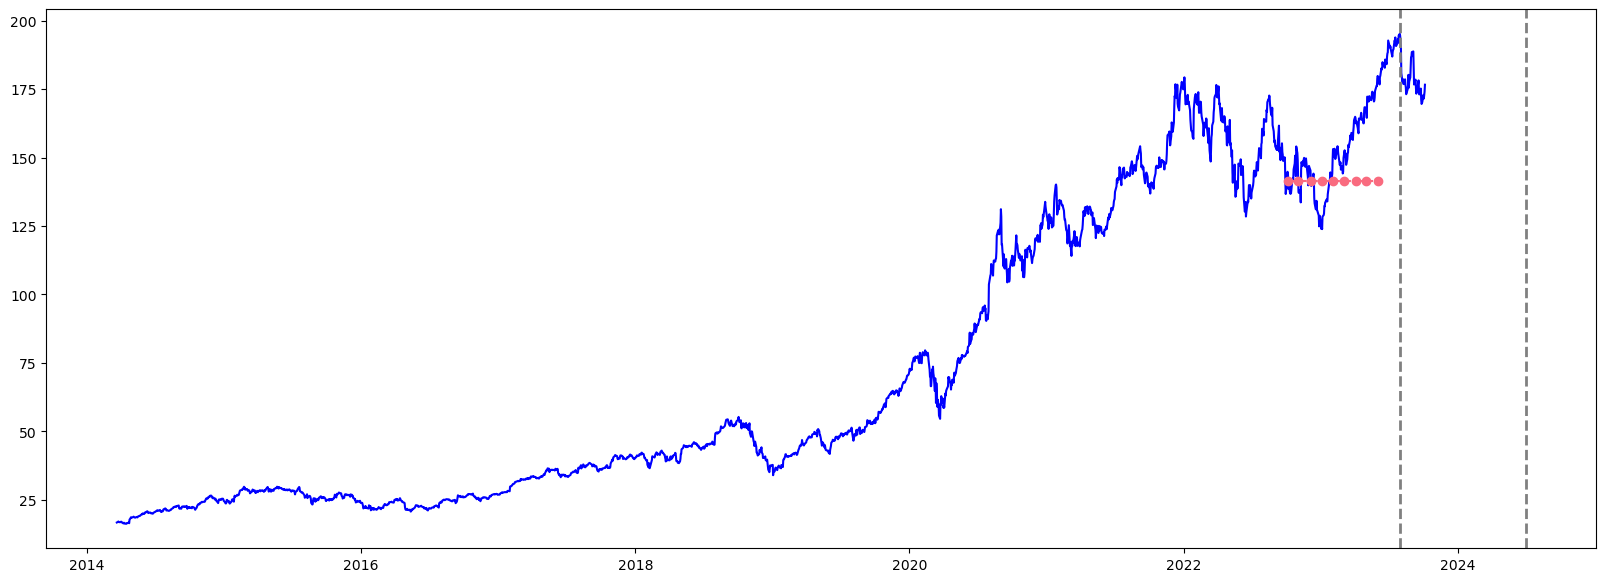

In [59]:
# import matplotlib.pyplot as plt

test_2023_8 = final_df.copy()

# 원래 값과 수정된 값 그래프 그리기
column_name = 'y'

plt.figure(figsize=(20, 7))
# 2024-07-01 이전까지의 데이터만 선택
filtered_df = df_full[df_full['Date'] <= cutoff]
plt.plot(filtered_df['Date'], filtered_df[column_name], label='Original Values', color='blue', linestyle='-')

# '현재월' 값을 datetime 형식으로 변환
test_2023_8['현재월'] = pd.to_datetime(test_2023_8['현재월'])

# 날짜와 Pred+3 값을 저장할 리스트
all_dates = []
all_preds = []

# test_2023_8의 각 row에 대해 예측 값 수집 및 그래프 그리기
for i in range(len(test_2023_8)):
    # 예측 값의 날짜를 +3 달 추가
    date = test_2023_8['현재월'].iloc[i] + pd.DateOffset(months=3)
    
    # Pred+3 값을 저장
    all_dates.append(date)
    all_preds.append(test_2023_8['Pred+3'].iloc[i])

    # 개별 점 추가
    plt.plot(date, test_2023_8['Pred+3'].iloc[i], color='#F96B7F', linestyle='', marker='o')

# 빨간 동그라미들을 점선으로 연결
plt.plot(all_dates, all_preds, color='#F96B7F', linestyle='--', label='Predicted Trend')

# 2023-08-01과 2024-05-01에 빨간색 점선 추가
# plt.axvline(pd.to_datetime('2023-08-01'), color='grey', linestyle='--', linewidth=2, label='2023-08-01')
plt.axvline(pd.to_datetime(cutoff), color='grey', linestyle='--', linewidth=2, label = cutoff)

# 그래프에 타이틀, 축, 범례, 그리드 추가
# plt.title(f'Comparison of Original and Predicted Values for {column_name}')
# plt.xlabel('ds')
# plt.ylabel(column_name)
# plt.grid(True)
# plt.legend()

# 그래프 출력
plt.show()